# [NOTE] This notebook is not optimised for performance. See E2E notebook best performance

In [1]:
import sys
sys.path.append("../")
import axo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from qkeras.utils import _add_supported_quantized_objects
from qkeras import quantized_bits
co = {}; _add_supported_quantized_objects(co)
import tensorflow as tf
K = tf.keras.backend

from axo import data_util
from axo import losses

from axo import models

from axo import metric

import gc
import re
import pprint
import json

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
import mplhep as hep

# DataLoader

## Loading the data

In [2]:
# BKG CONFIG

config_bkg = {}
config_bkg["file_path"] = "../../axo-2024D-E/ZB_preprocessed_2024E_381148.h5"
config_bkg["train_sector"] = [0, 2000000]
config_bkg["test_sector"] = [2000000, 8000000]
config_bkg["object_ranges"] = {'met': 0, 'egs': (1, 13), 'muons': (13, 21), 'jets': (21, 33)}
config_bkg["constituents"] = constituents = {
    "MET": [True],
    "EGAMMA": [True,True,True,True,False,False,False,False,False,False,False,False],
    "MUON": [True,True,True,True,False,False,False,False],
    "JET": [True,True,True,True,True,True,True,True,True,True,False,False]}


# SIG CONFIG

config_sig = {}
config_sig["file_path"] = "../../axo-2024D-E/BSM_preprocessed.h5"
config_sig["MAX_NUM_SIGNALS"] = 20000
config_sig["object_ranges"] = {'met': 0, 'egs': (1, 13), 'muons': (13, 21), 'jets': (21, 33)}
config_sig["constituents"] = constituents = {
    "MET": [True],
    "EGAMMA": [True,True,True,True,False,False,False,False,False,False,False,False],
    "MUON": [True,True,True,True,False,False,False,False],
    "JET": [True,True,True,True,True,True,True,True,True,True,False,False]}

In [3]:
config_master = {}
config_master["File_paths"] = {"BACKGROUND_PATH":"../../axo-2024D-E/ZB_preprocessed_2024E_381148.h5",
                               "SIGNAL_PATH":"../../axo-2024D-E/BSM_preprocessed.h5"}
config_master["Read_configs"] = {"BACKGROUND":config_bkg,
                                 "SIGNAL":config_sig}
config_master["Saturation_configs"] = {"saturation_mode":"mask"}
config_master["Normalisation_configs"] = {"scheme":"RobustScaler_pow2(5,95,-2,2)",
                                          "norm_ignore_zeros":True}
config_master["Quantization_configs"] = {"quantize_bits":[8,5]}
config_master["Processed_data_path"] = "./Data.h5" ### <----- 

In [4]:
BACKGROUND_PATH = config_master["File_paths"]["BACKGROUND_PATH"]
SIGNAL_PATH = config_master["File_paths"]["BACKGROUND_PATH"]

# PROCESS = "GluGluHToBB_M-125"
# data_background = data_util.utils._get_background(file_path=BACKGROUND_PATH)
# data_process = data_util._get_signal(file_path=SIGNAL_PATH,process=PROCESS)

## Step 1: Reading the data

In [5]:
config_bkg = config_master["Read_configs"]["BACKGROUND"]
config_sig = config_master["Read_configs"]["SIGNAL"]

In [6]:
data_bkg = data_util._read.get_data_background(config=config_bkg)
data_sig = data_util._read.get_data_signal(config=config_sig)

## Step 2

In [7]:
saturation_mode = config_master["Saturation_configs"]["saturation_mode"]

data_bkg = data_util._saturation._remove_saturation(data_bkg,config_bkg["constituents"],saturation_mode=saturation_mode)
data_sig = data_util._saturation._remove_saturation(data_sig,config_sig["constituents"],saturation_mode=saturation_mode)

## Step 3

In [8]:
# Normalisation Config
scheme = config_master["Normalisation_configs"]["scheme"]
norm_ignore_zeros = config_master["Normalisation_configs"]["norm_ignore_zeros"]

data_bkg, data_sig, norm_bias, norm_scale = data_util._normalise(data_bkg = data_bkg,
                                                                            data_sig = data_sig,
                                                                            scheme = scheme,
                                                                            norm_ignore_zeros = norm_ignore_zeros)

## Step 4

In [9]:
quantize_bits = config_master["Quantization_configs"]["quantize_bits"]

data_bkg, data_sig = data_util._enforce_limit(data_bkg = data_bkg,
                                              data_sig = data_sig,
                                              quantize_bits = quantize_bits)

## Step 5

In [10]:
data_util._pack(data_bkg = data_bkg,
                data_sig=data_sig,
                config=config_master,
                norm_bias=norm_bias,
                norm_scale=norm_scale
               )

# Model Training and Setup

## Data

### Read the data 

In [11]:


# Loading the data from the processed files :)
f = h5py.File("./Data.h5","r")
x_train = f["Background_data"]["Train"]["DATA"][:]
x_test = f["Background_data"]["Test"]["DATA"][:]

scale = f["Normalisation"]["norm_scale"][:]
bias = f["Normalisation"]["norm_bias"][:]

data_config = json.loads(f.attrs["config"])
constituents = data_config["Read_configs"]["BACKGROUND"]["constituents"]

### Flatten the data

In [12]:
x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_test = np.reshape(x_test,(x_test.shape[0],-1))

In [13]:
# Model config remains same irrespective of the training procedure: AE, VAE, NAE, CONTRASTIVE

model_config = {}

model_config["encoder_config"] = {"nodes":[28,15]}
model_config["latent_dim"] = 8
model_config["decoder_config"] = {"nodes":[24,32,64,128,57]}
model_config["features"] = 57

model_config["ap_fixed_kernel"] = [6,2]
model_config["ap_fixed_bias"] = [10,6]
model_config["ap_fixed_activation"] = [10,6]
model_config["ap_fixed_data"] = [8,5] 
model_config["alpha"] = 1
model_config["beta"] = 0.604108559135001


## Loss and the Model

In [20]:
loss_kld = losses.kld()

loss_reco = losses.cyl_PtPz_loss(norm_scales=scale,
                            norm_biases=bias,
                            mask=constituents,
                            name="Reco_loss"
                                )


vae = models.VariationalAutoEncoder(config = model_config,
                             reco_loss = loss_reco,
                             kld_loss= loss_kld
                            )


In [21]:
opt = Adam(learning_rate=1e-3)
vae.compile(optimizer=opt)

## Fitting the model

In [23]:
vae.fit(x_train,x_train,
                # callbacks=callbacks,
                batch_size=16000,
                epochs=50,
                validation_split=0.1,
                shuffle=True,
                verbose = 1
                #callbacks = callbacks.callbacks
            )

Epoch 1/50
113/113 [==============================] - 1s 6ms/step - loss: 1.1203 - reco_loss: 0.6094 - kl_loss: 0.5116 - val_loss: 1.4385 - val_reco_loss: 0.8600 - val_kl_loss: 0.5805
Epoch 2/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1009 - reco_loss: 0.5951 - kl_loss: 0.5088 - val_loss: 1.2551 - val_reco_loss: 0.7248 - val_kl_loss: 0.5310
Epoch 3/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1121 - reco_loss: 0.5971 - kl_loss: 0.5066 - val_loss: 1.4813 - val_reco_loss: 0.9457 - val_kl_loss: 0.5383
Epoch 4/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1034 - reco_loss: 0.5894 - kl_loss: 0.5018 - val_loss: 1.3174 - val_reco_loss: 0.7986 - val_kl_loss: 0.5196
Epoch 5/50
113/113 [==============================] - 1s 5ms/step - loss: 1.0750 - reco_loss: 0.5710 - kl_loss: 0.5014 - val_loss: 1.1761 - val_reco_loss: 0.7602 - val_kl_loss: 0.4169
Epoch 6/50
113/113 [==============================] - 1s 5ms/step - loss: 1.0684

### Trimming the model

In [24]:
model = tf.keras.Sequential(vae.encoder.layers[:4])

# Model Evaluation

### Getting AXO Score

In [25]:
thres_config = {
    "target_rate":[0.15,0.2,0.3,0.6,1,2,3,5,10],
    "bc_khz":11245.6 * 2.544,
    "data_path":"./Data.h5",
    "ht_threshold":280,
    "precision":[18,5],
    "alpha":1
}

In [26]:
model = tf.keras.Sequential(vae.encoder.layers[:4])
axo_man = metric.axo_threshold_manager(model=model,config=thres_config)

38/38 [==============================] - 0s 3ms/step


In [27]:
axo_man.get_score(0.15)

,Signal Name,AXO SCORE,AXO pure SCORE,L1 SCORE,HT SCORE,AXO Improvement
0,GluGluHToBB_M-125,12.393472,0.000000,99.309308,99.392859,0.000000
1,GluGluHToGG_M-125,0.041167,0.000000,88.432049,67.725004,0.000000
2,GluGluHToGG_M-90,0.035565,0.000000,80.723504,51.011076,0.000000
3,GluGluHToTauTau,0.090371,0.000000,40.104428,21.488101,0.000000
4,GluGlutoHHto2B2WtoLNu2Q,1.147482,0.000000,87.218892,86.762973,0.000000
5,HHHTo6B,6.981153,0.000000,95.461438,98.191075,0.000000
6,HHHto4B2Tau,4.670672,0.000000,96.498349,97.245224,0.000000
7,HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm,1.110329,0.000000,42.696203,38.688187,0.000000
8,HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm,4.312733,0.000000,78.117094,71.123961,0.000000
9,HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm,0.081041,0.000000,30.360128,20.042547,0.000000


### Plots

In [28]:
dist_plot = metric.distribution_plots(model = model, config=thres_config)

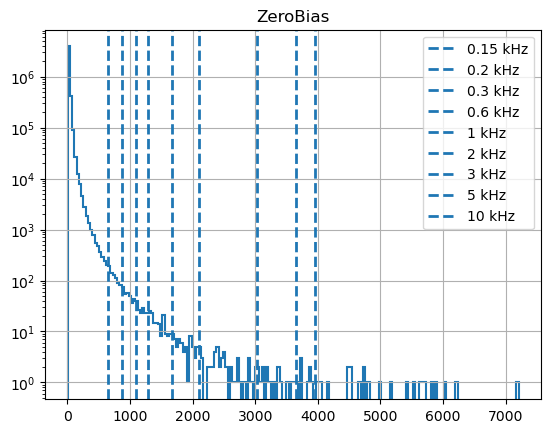

In [29]:
plt.Figure(figsize=(4,3))
hep.histplot(dist_plot.background_hist)
plt.yscale("log")
plt.title("ZeroBias")
for thres in axo_man.threshold.keys():
    plt.axvline(x=axo_man.threshold[thres], linestyle='--', linewidth=2, label = f"{thres} kHz")
plt.grid()
plt.legend()

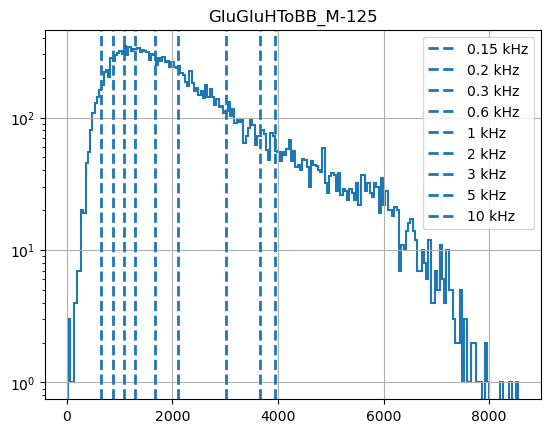

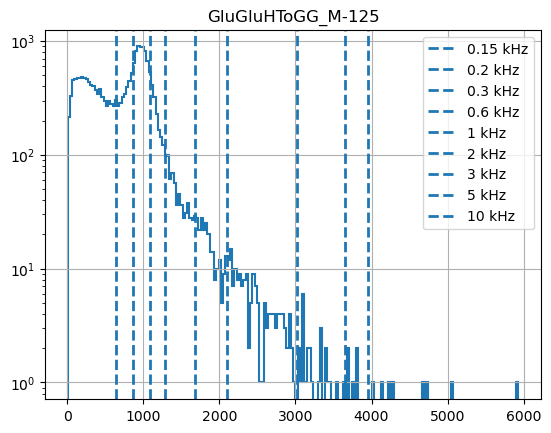

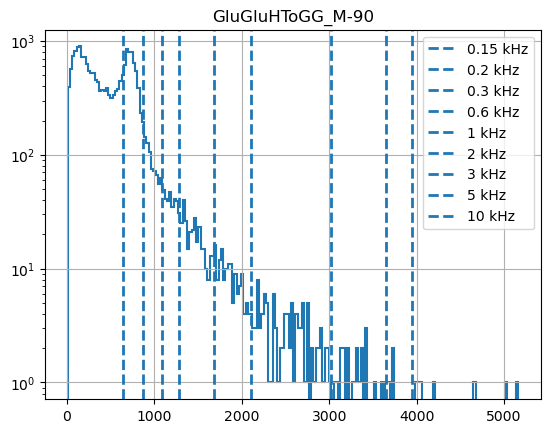

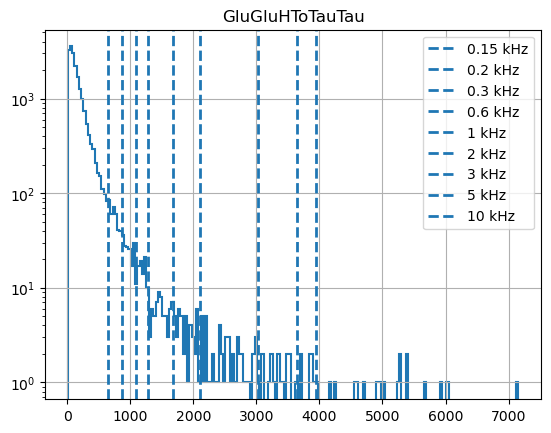

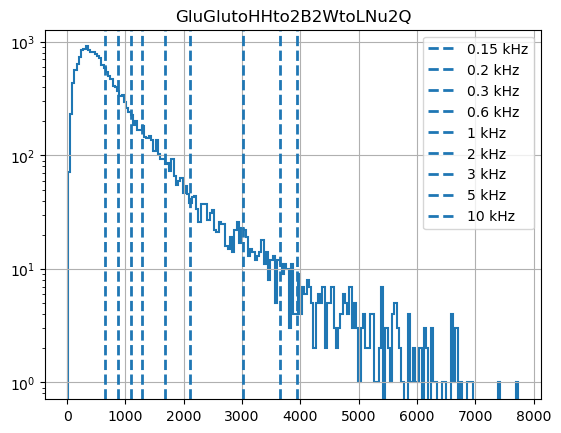

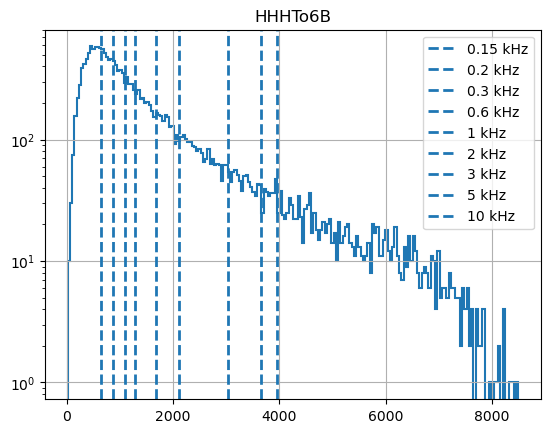

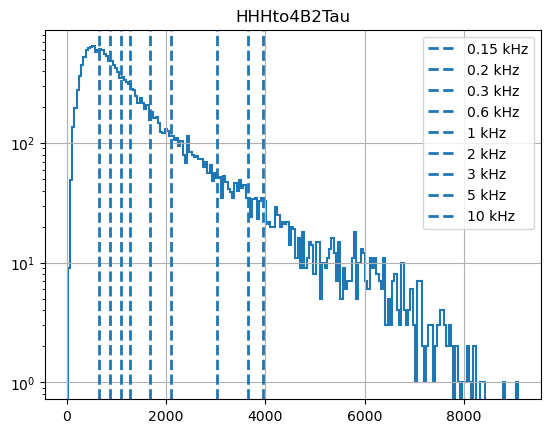

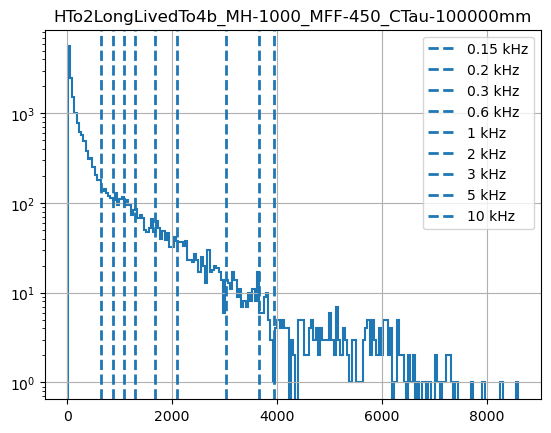

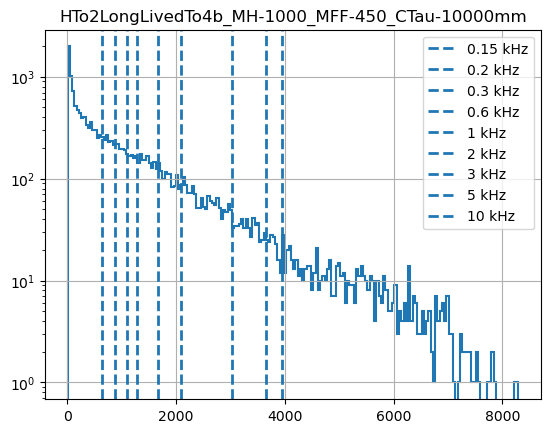

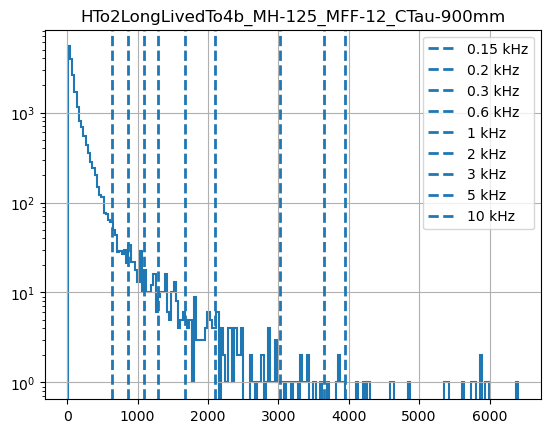

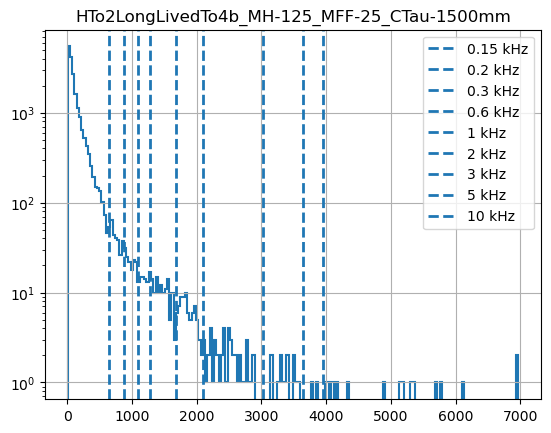

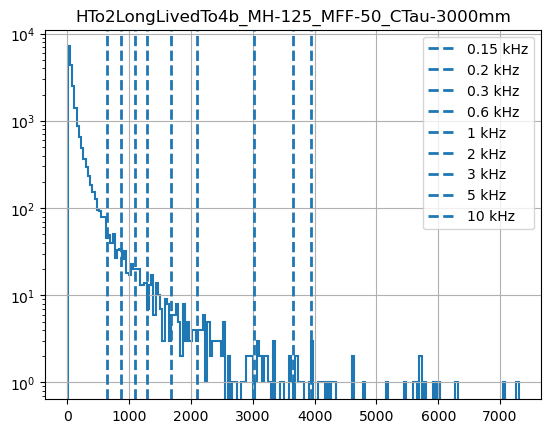

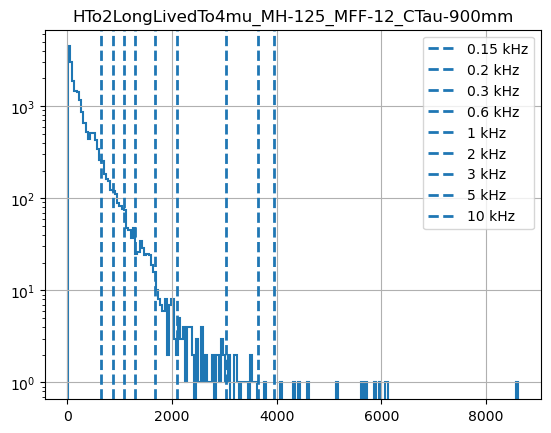

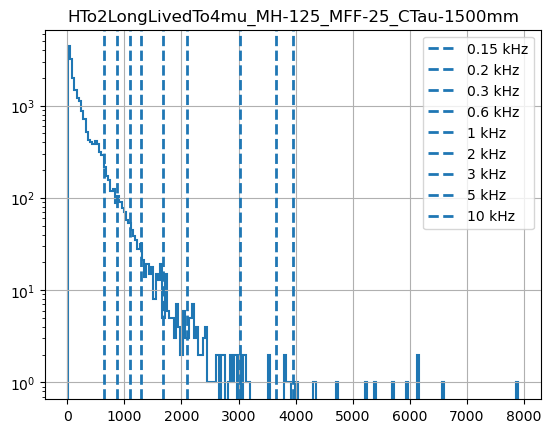

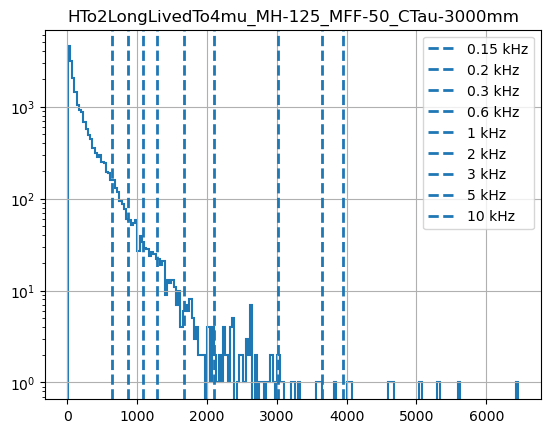

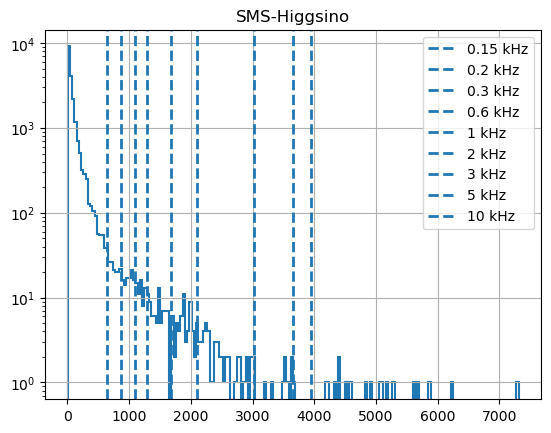

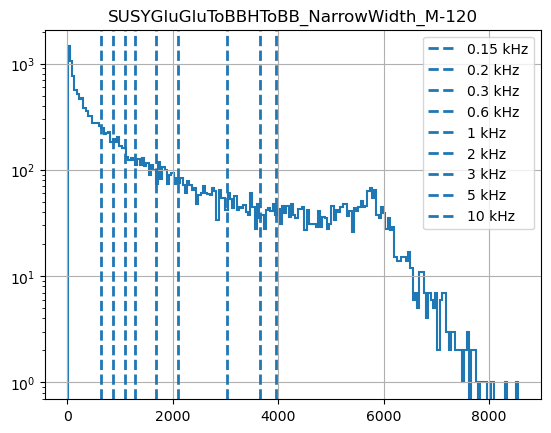

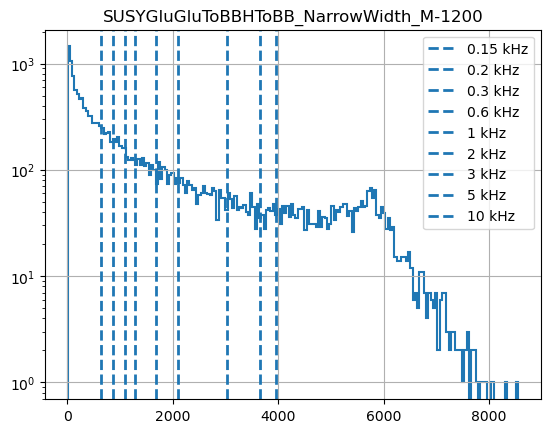

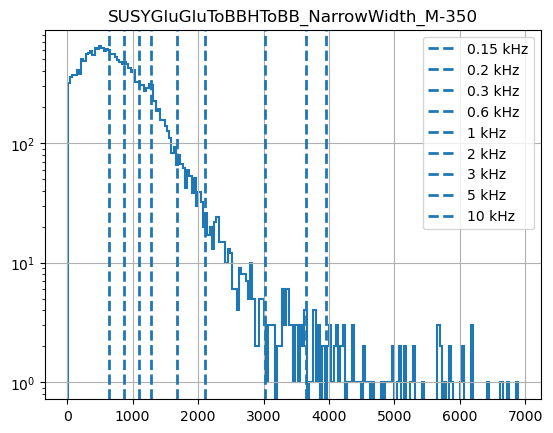

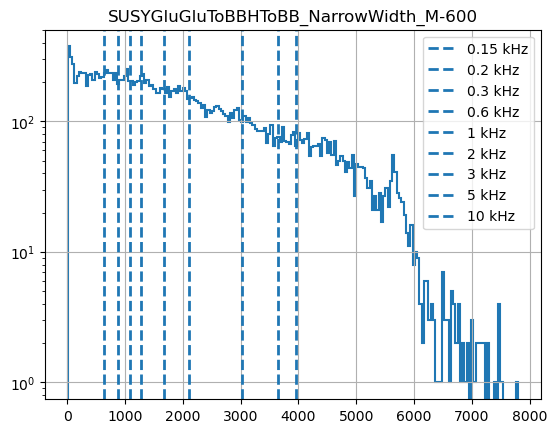

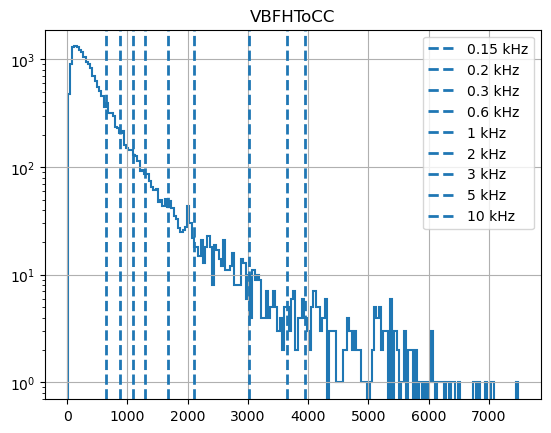

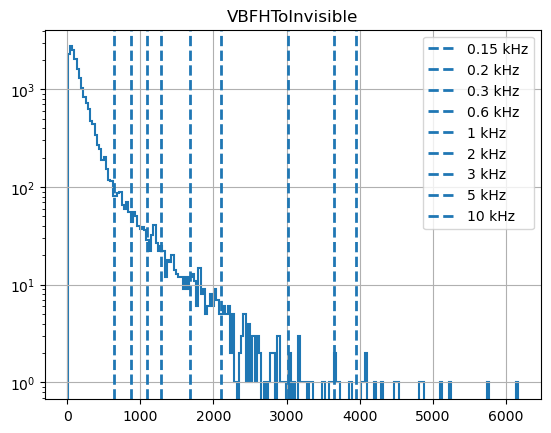

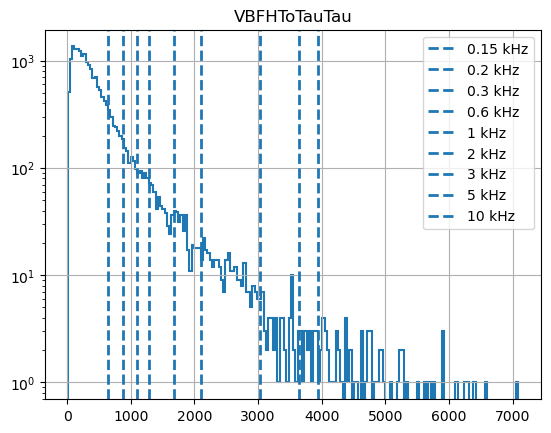

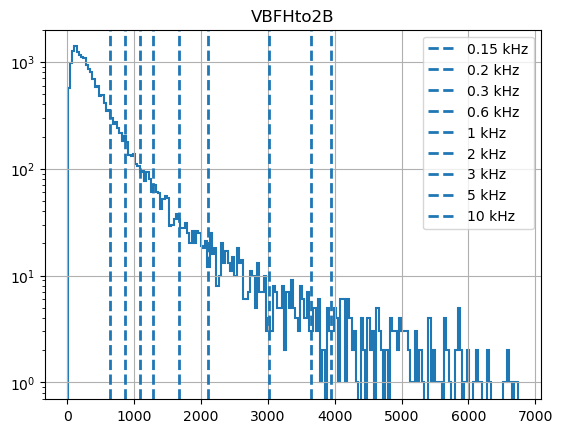

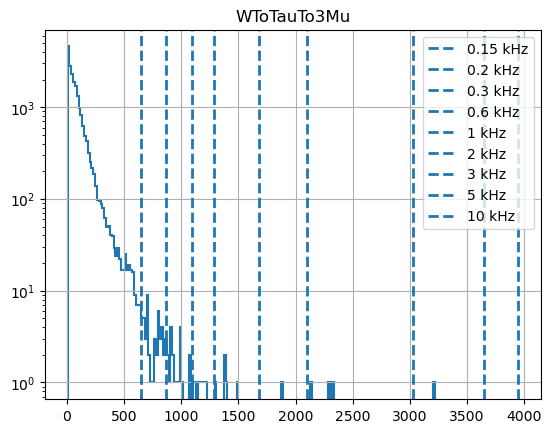

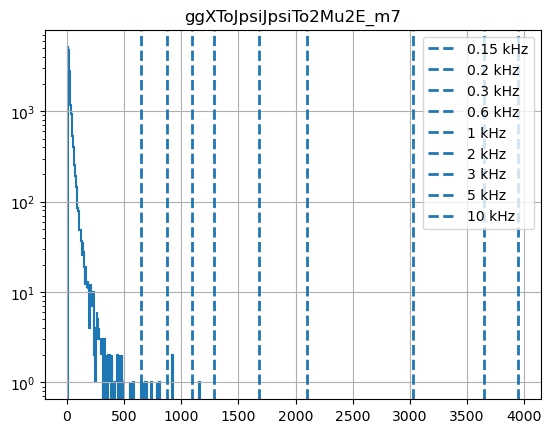

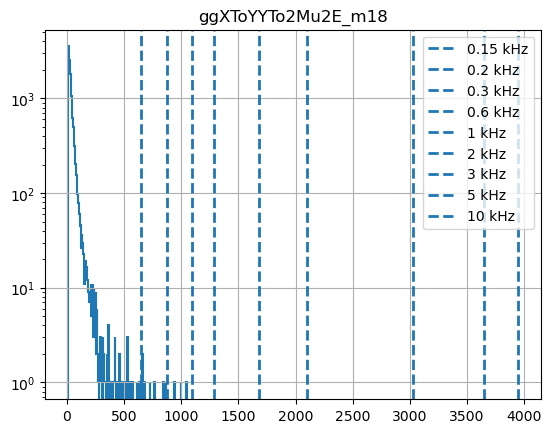

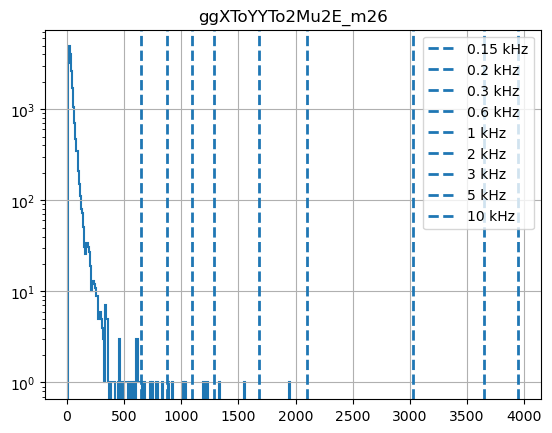

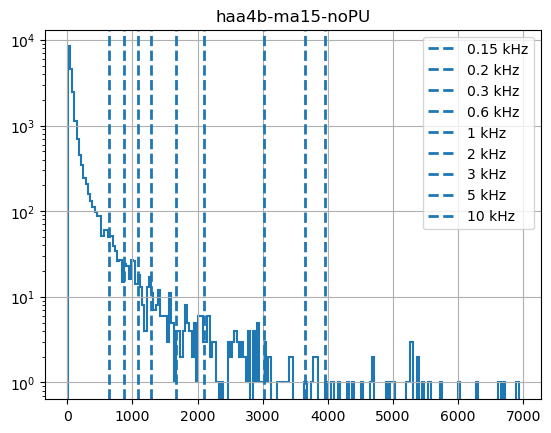

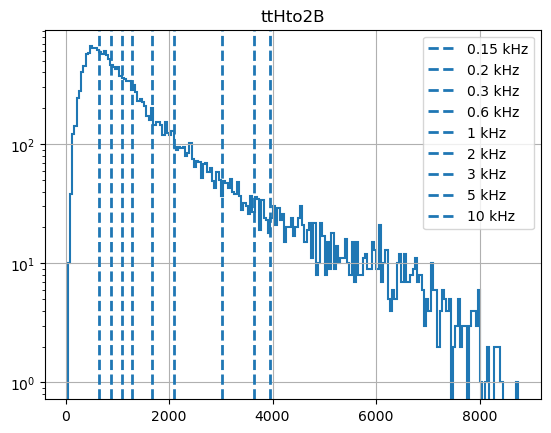

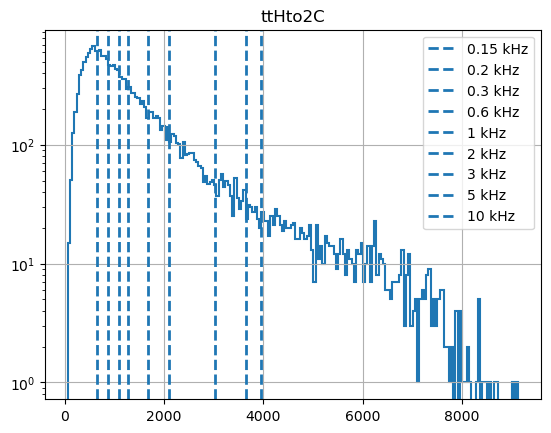

In [30]:
for i,k in enumerate(dist_plot.signal_hist.keys()):
    hep.histplot(dist_plot.signal_hist[k])
    plt.yscale("log")
    for thres in axo_man.threshold.keys():
        plt.axvline(x=axo_man.threshold[thres], linestyle='--', linewidth=2, label = f"{thres} kHz")
    plt.grid()
    plt.title(k)
    plt.legend()
    plt.show()
    